### Accuracy Metrics

We evaluate the decision accuracy and how it changes with time in this notebook

We look at several metrics

1. Accuracy
2. False Positive Rate
3. Recall


#### Suspicious

As with the operational metrics, we use four strategies to include the records marked as "suspicious" in our analysis

1. correct with time penalty
2. All approve
3. All deny
4. Ignore


In [1]:
import os
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import itertools
from sklearn.utils import resample
from functools import reduce

In [14]:
from facct22.utils import get_db_con

from facct22.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    ttests_operational_metrics, assign_conf_mat_cell, _modify_value_and_time, chi_square_test
)

In [4]:
cred_file = '../../conf/credentials.yaml'
engine = get_db_con(cred_file)

##### Functions

In [5]:
def get_accuracy(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    
    for g, df in grpobj:
        means = list()

        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            msk = (t['conf_mat']=='tp') | (t['conf_mat']=='tn') 
            m = len(t[msk])/len(t)
            
            means.append(m)
        
        
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
               
        msk = (df['conf_mat']=='tp') | (df['conf_mat']=='tn') 
        m = len(df[msk])/len(df)
#         m = len(df[msk])/500
        d['mean'] = m
 
        d['mean_bootstrap'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)


def get_recall(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        means = list()

        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            tp = (t['conf_mat']=='tp') 
            fn = (t['conf_mat']=='fn')
            
            m = len(t[tp]) / (len(t[tp]) + len(t[fn]))
            means.append(m)
    
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
                
        tp = (df['conf_mat']=='tp') 
        fn = (df['conf_mat']=='fn')

        m = len(df[tp]) / (len(df[tp]) + len(df[fn]))
        d['mean'] = m
        d['mean_bootstrap'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)


def get_fpr(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        means = list()
    
        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            fp = (t['conf_mat']=='fp') 
            tn = (t['conf_mat']=='tn')
            
            m = len(t[fp]) / (len(t[fp]) + len(t[tn]))
            means.append(m)
    
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
            
        fp = (df['conf_mat']=='fp') 
        tn = (df['conf_mat']=='tn')

        m = len(df[fp]) / (len(df[fp]) + len(df[tn]))
        d['mean'] = m
        d['mean_bootstrap'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)


def get_precision(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        means = list()
    
        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            tp = (t['conf_mat']=='tp')
            fp = (t['conf_mat']=='fp') 
            
            m = len(t[tp]) / (len(t[fp]) + len(t[tp]))
            means.append(m)
    
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
        
        tp = (df['conf_mat']=='tp')
        fp = (df['conf_mat']=='fp') 
        m = len(df[tp]) / (len(df[fp]) + len(df[tp]))
        
        d['mean'] = m
        d['mean_bootstrap'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)
    


def plot_time_vs_accuracy_metric(accuracy_metric, time_metric, group_order, title='', ylabel='', confidence=0.9, xlim=[], ylim=[], save_target=None):
    
    merged = accuracy_metric.merge(
        time_metric, on='group', suffixes=('_met', '_dt')
    )

    fig, ax = plt.subplots(dpi=200, figsize=(4,3))
    
    for i, g in enumerate(group_order):
        msk = merged['group'] == g
        df = merged[msk]
        
        interval = stats.norm.ppf(1-(1-confidence)/2)

        ax.errorbar(
            df['mean_dt'],
            df['mean_met'],
            yerr=df['se_met'] * interval,
            xerr=df['se_dt'] * interval,
    #         fmt='o',
            color=colors[i],
    #         label=g
        )
        ax.scatter(df['mean_dt'], df['mean_met'], color=colors[i], label=g)

    ax.legend(frameon=False, bbox_to_anchor=(1.3, 1))
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mean Decision Time(s)')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)
    sns.despine()
    
    if save_target is not None:
        plt.savefig(
            save_target, dpi='figure', format='png', bbox_inches='tight'
        )

    
    

#### Decisions

In [6]:
all_decisions = get_all_decisions(engine, schemas, users, groups)
msk = all_decisions['trx_amnt'] > 2000
all_decisions.loc[msk, 'trx_amnt'] = 2000

In [7]:
suspicious_msk = all_decisions['decision'] == 'suspicious'

In [8]:
params={
    'fn': -3, 
    'p_loss_trx': 0.5, # prob of losing this transaction
    'cust_worth': 3, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

#### Time vs Accuracy across groups

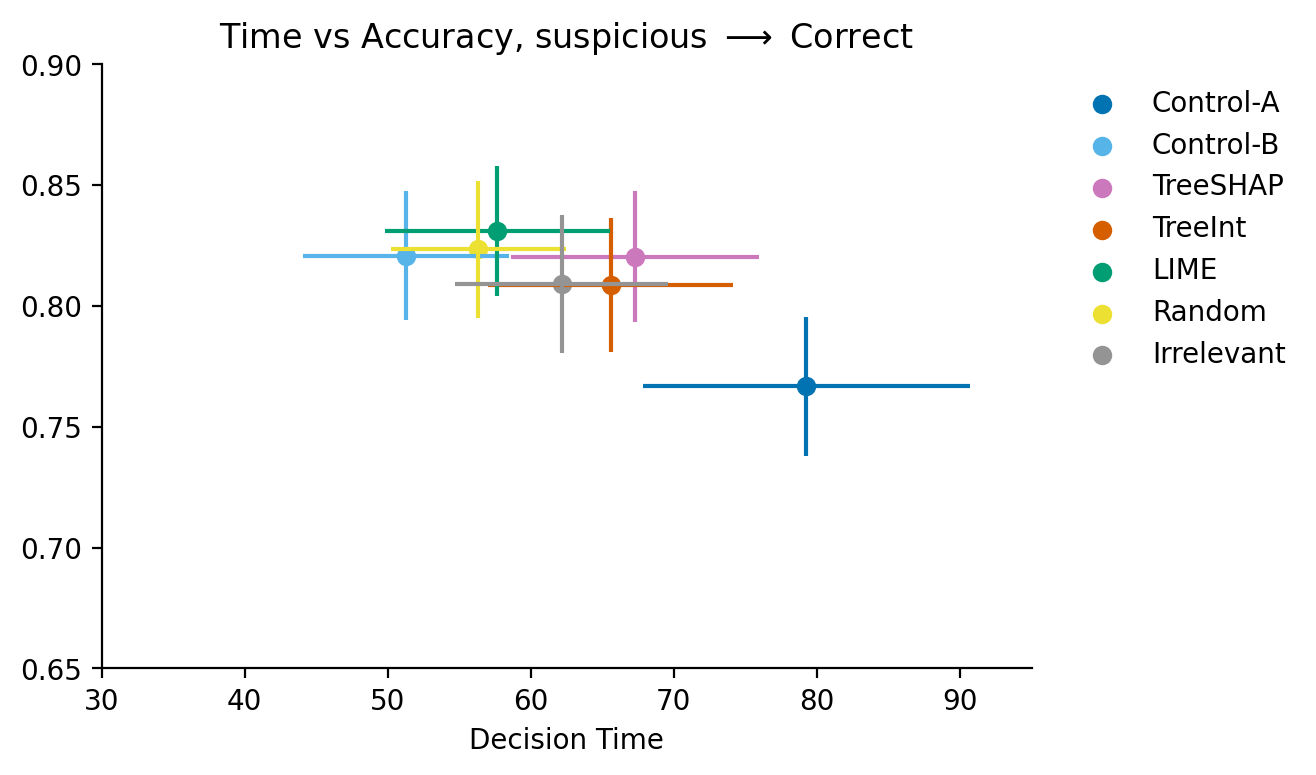

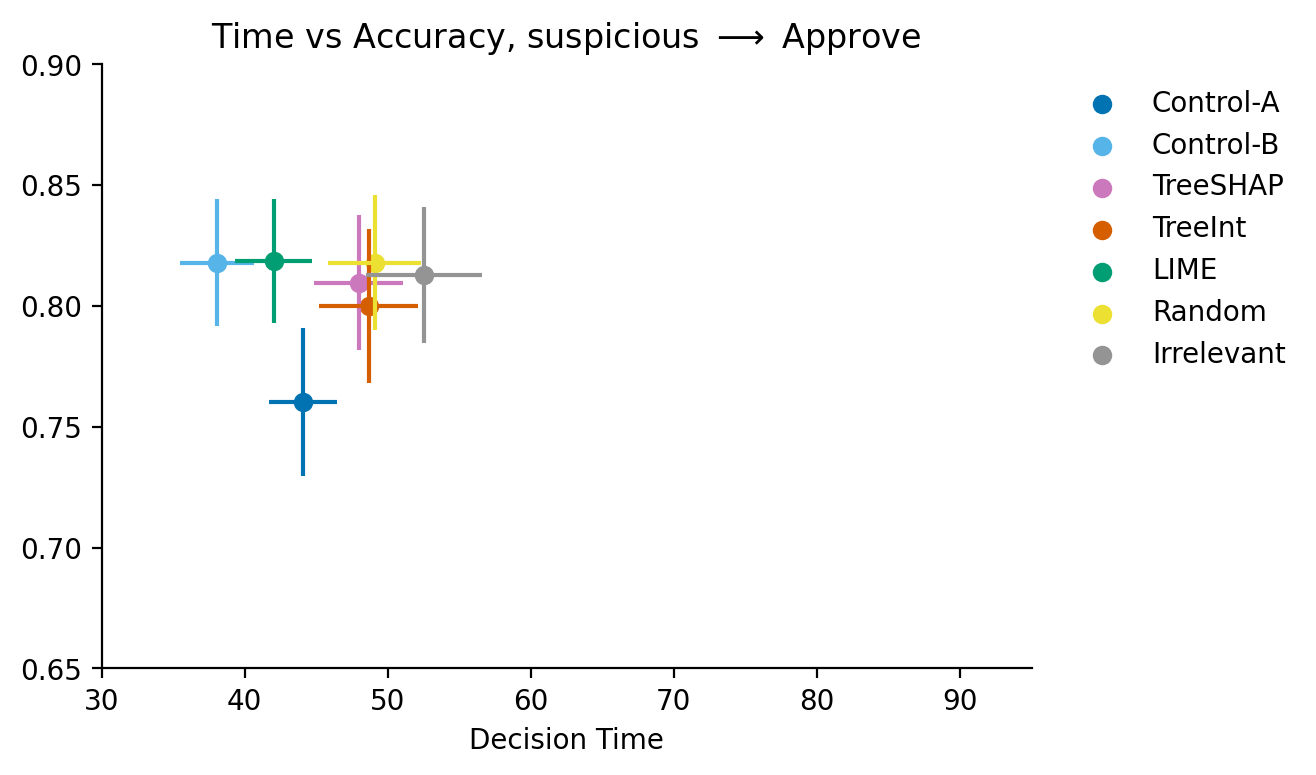

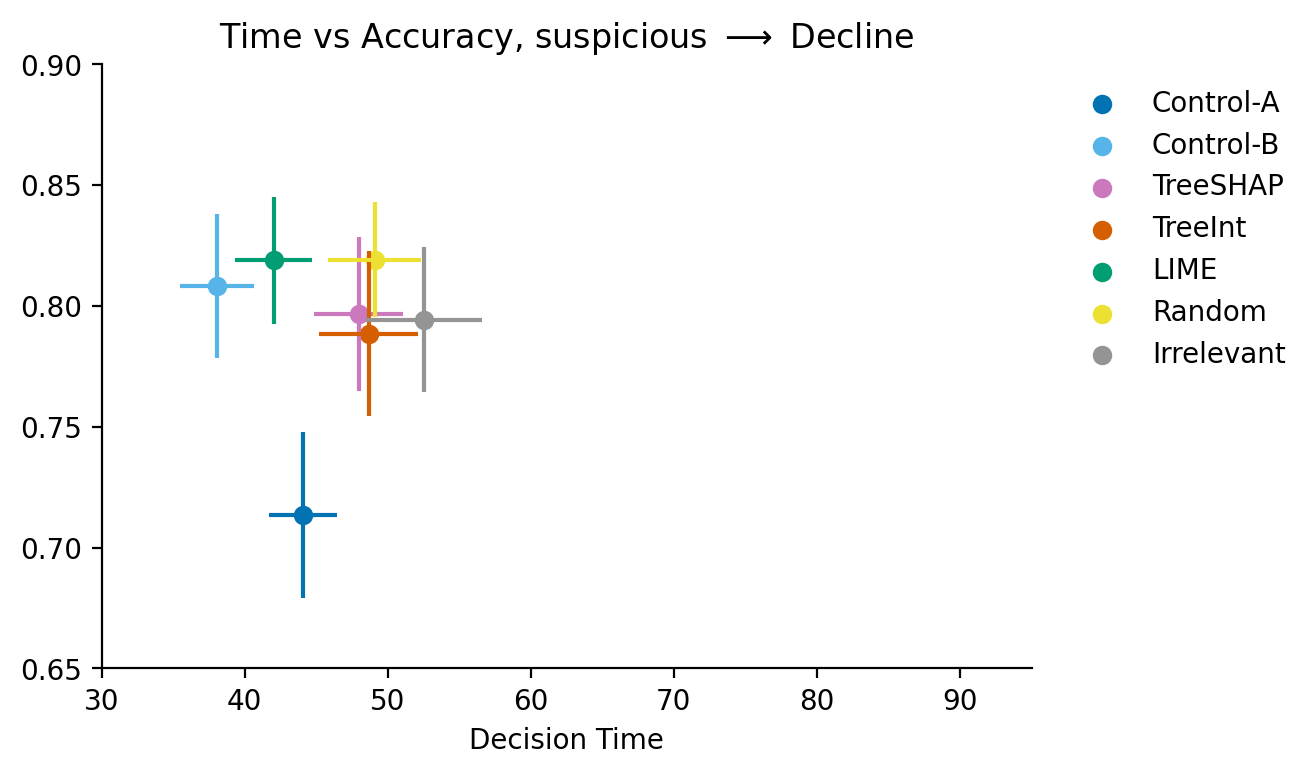

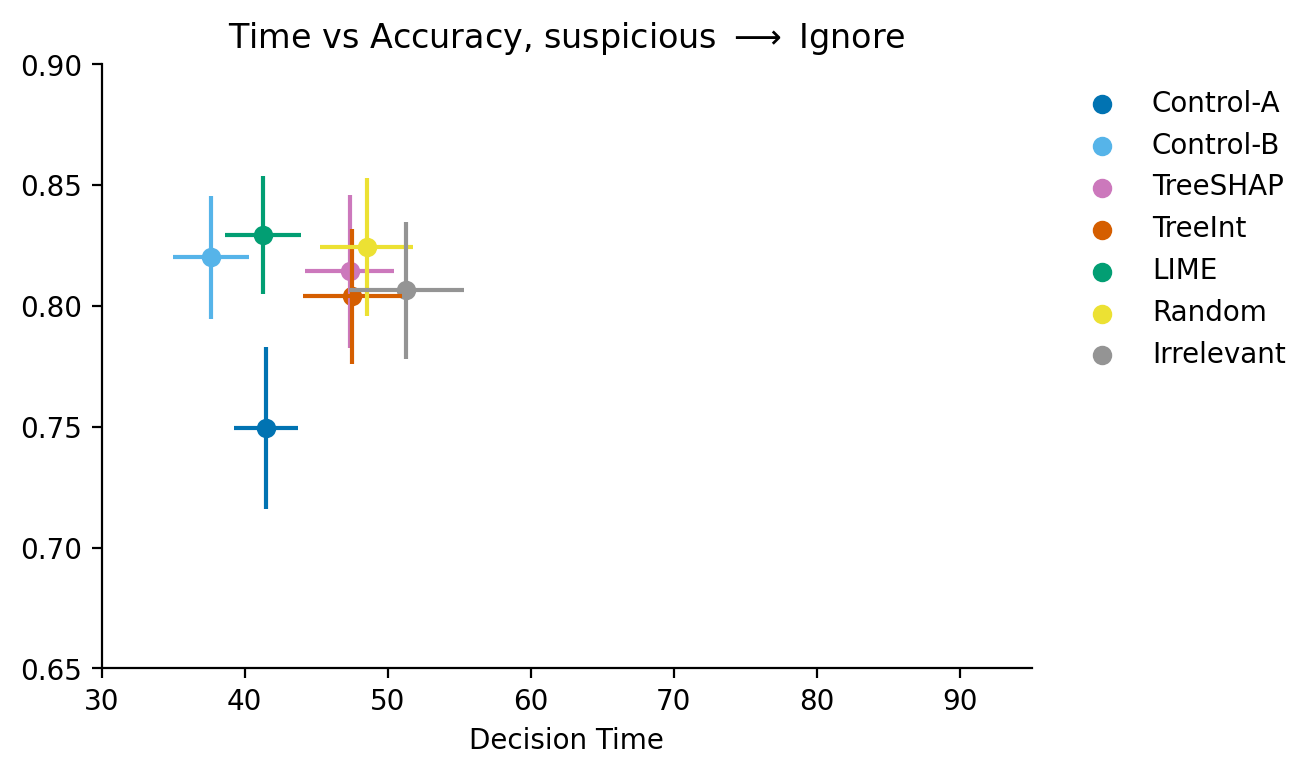

In [104]:
xlim = [30, 95]
ylim = [0.65, 0.90]

acc = get_accuracy(all_decisions, 'correct',)
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(
    acc, dt_df, group_order, 
    title='Time vs Accuracy, suspicious $\longrightarrow$ Correct', 
    xlim=xlim, ylim=ylim
)

# acc = get_accuracy(all_decisions, 'approve')
# dt_df = dt(all_decisions, params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(
#     acc, dt_df, group_order, 
#     title='Time vs Accuracy, suspicious $\longrightarrow$ Approve', 
#     xlim=xlim, ylim=ylim
# )

# acc = get_accuracy(all_decisions, 'decline')
# dt_df = dt(all_decisions, params, 'decline', ['group'])
# plot_time_vs_accuracy_metric(
#     acc, dt_df, group_order, 
#     title='Time vs Accuracy, suspicious $\longrightarrow$ Decline', 
#     xlim=xlim, ylim=ylim
# )

# acc = get_accuracy(all_decisions[~suspicious_msk], 'approve')
# dt_df = dt(all_decisions[~suspicious_msk], params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(
#     acc, dt_df, group_order, 
#     title='Time vs Accuracy, suspicious $\longrightarrow$ Ignore', 
#     xlim=xlim, ylim=ylim
# )

#### For the paper

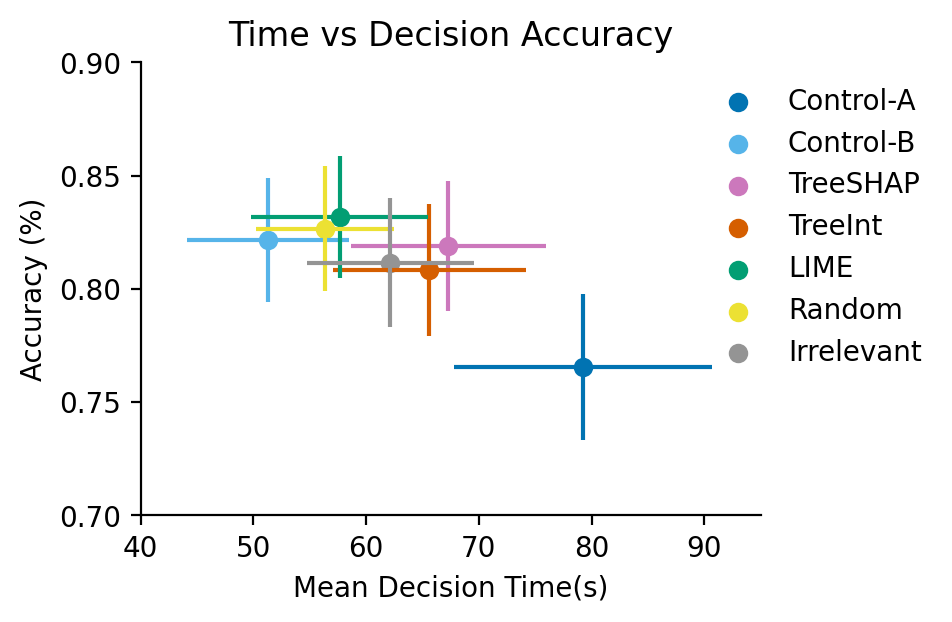

In [24]:
xlim = [40, 95]
ylim = [0.70, 0.90]

acc = get_accuracy(all_decisions, 'correct',n_samples=500, n_iterations=1000)
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(
    acc, dt_df, group_order, 
    title='Time vs Decision Accuracy', 
    xlim=xlim, ylim=ylim,
    ylabel='Accuracy (%)',
#     save_target='results/figures_for_paper/acc_vs_time.png'
)


In [25]:
acc

,group,mean,mean_bootstrap,n,se,var
0,Control-A,0.765657,0.765376,495,0.019555,0.189293
1,Control-B,0.821643,0.821650,499,0.016632,0.138036
2,Irrelevant,0.811623,0.810822,499,0.017301,0.149357
3,LIME,0.831663,0.832250,499,0.016375,0.133803
4,Random,0.826613,0.826802,496,0.016730,0.138825
5,TreeInt,0.808468,0.808648,496,0.017672,0.154901
6,TreeSHAP,0.818913,0.819962,497,0.017551,0.153089


#### Accuracy difference vs PDR similarity

There's a significant difference in accuracy between Control-A and Control-B, but PDR is very similar. Why?

In [10]:
dc = _modify_value_and_time(all_decisions, params, 'correct')
dc['potential_revenue'] = dc.apply(
        lambda x: x['trx_amnt'] * (1 + (params['cust_worth'] * params['p_return_cust'])) if x['label']==0 else 0, 
        axis=1
)
msk = dc['group'].str.contains('Control')
# dc['']

In [11]:
dc.head()

,xplz_id,group,user_name,trx_amnt,decision,decision_time,label,conf_mat,decision_value,modified_time,potential_revenue
0,0005e73512cc6b51164de77a492947cb,Control-B,j,206.86,approved,24,0.0,tn,827.44,24,827.44
1,00199cf0e179eee21bbc464dfdd26695,Irrelevant,n,102.69,approved,126,1.0,fn,-308.07,126,0.00
2,0023ade89e3b6dedae14bced27d2e02a,Control-A,n,88.78,approved,61,0.0,tn,355.12,61,355.12
3,0053a4cc33ce725779c115d4c8fe392b,Control-B,j,137.94,approved,8,0.0,tn,551.76,8,551.76
4,005ba4ef23b2226267fe9ab620fe1d10,Irrelevant,t,190.00,approved,39,0.0,tn,760.00,39,760.00


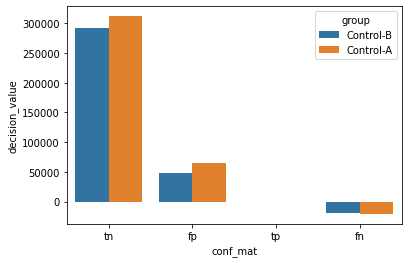

In [17]:
sns.barplot(
    data=dc[msk],
    x='conf_mat',
    y='decision_value',
    hue='group',
    estimator=sum,
    ci=None
)

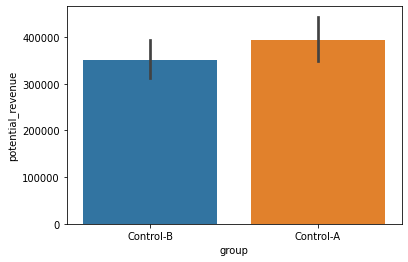

In [13]:
sns.barplot(
    data=dc[msk],
    x='group',
    y='potential_revenue',
#     hue='group',
    estimator=sum,
    c
)

In [31]:
grp_object = dc.groupby(['group', 'conf_mat'])
sums = grp_object.sum()[['decision_value', 'potential_revenue']].rename(columns={
    'decision_value': 'total_decision_value',
    'potential_revenue': 'total_potential_revenue'
})

counts = grp_object.count()['decision_value']
counts.name = 'trx_count'
means = grp_object.mean()['trx_amnt']
means.name = 'mean_trx_value'

In [32]:
sums.join(counts).join(means)

total_decision_value  total_potential_revenue  trx_count  \
group      conf_mat                                                             
Control-A  fn                  -21057.000                     0.00         37   
           fp                   64741.728                 80927.16         79   
           tn                  312036.000                312036.00        344   
           tp                       0.000                     0.00         35   
Control-B  fn                  -19102.800                     0.00         38   
           fp                   47756.128                 59695.16         51   
           tn                  291889.040                291889.04        373   
           tp                       0.000                     0.00         37   
Irrelevant fn                  -27006.240                     0.00         54   
           fp                   37107.296                 46384.12         40   
           tn                  331484.880                331484.88        382   
           tp                       0.000                     0.00         23   
LIME       fn                  -31380.270                     0.00         46   
           fp                   32799.840                 40999.80         38   
           tn                  302414.480                302414.48        386   
           tp                       0.000                     0.00         29   
Random     fn                  -25740.720                     0.00         46   
           fp                   39543.488                 49429.36         40   
           tn                  347625.840                347625.84        381   
           tp                       0.000                     0.00         29   
TreeInt    fn                  -24878.880                     0.00         44   
           fp                   45180.096                 56475.12         51   
           tn                  301970.040                301970.04        371   
           tp                       0.000                     0.00         30   
TreeSHAP   fn                  -27083.760                     0.00         45   
           fp                   30811.104                 38513.88         45   
           tn                  322162.680                322162.68        379   
           tp                       0.000                     0.00         28   

                     mean_trx_value  
group      conf_mat                  
Control-A  fn            189.702703  
           fp            256.098608  
           tn            226.770349  
           tp            171.993714  
Control-B  fn            167.568421  
           fp            292.623333  
           tn            195.636086  
           tp            262.628378  
Irrelevant fn            166.705185  
           fp            289.900750  
           tn            216.940366  
           tp            181.377826  
LIME       fn            227.393261  
           fp            269.735526  
           tn            195.864301  
           tp            373.090000  
Random     fn            186.526957  
           fp            308.933500  
           tn            228.100945  
           tp            223.475517  
TreeInt    fn            188.476364  
           fp            276.838824  
           tn            203.483854  
           tp            254.643000  
TreeSHAP   fn            200.620444  
           fp            213.966000  
           tn            212.508364  
           tp            245.868571

In [16]:
for g, df in grp_object:
#     df['potential_revenue'] = df.apply(
#         lambda x: x['trx_amnt'] * (1 + (params['cust_worth'] * params['p_return_cust'])) if x['label']==0 else 0, 
# #         lambda x: (4 * x['trx_amnt']) if x['label']==0 else 0,
#         axis=1
#     )
    
#     print(df.head())
#     for i in range(n_iterations):
#         t = resample(df, replace=True, n_samples=n)

#         m = 1 - (t['decision_value'].sum() / t['potential_revenue'].sum())
#         means.append(m)
    generated_revenue = df['decision_value'].sum()
    possible_revenue = df['potential_revenue'].sum()
    
    regret = 1 - float(generated_revenue / possible_revenue)
    print(g, generated_revenue, possible_revenue, regret)

#     df['decision_value'].sum() / df['potential_revenue'].sum()

Control-A 355720.728 392963.16 0.09477334211176436
Control-B 320542.368 351584.2 0.08829131684529623
Irrelevant 341585.936 377869.0 0.09602021864720311
LIME 303834.05000000005 343414.28 0.1152550499647248
Random 361428.608 397055.2 0.08972705054612051
TreeInt 322271.256 358445.16 0.10091893554930409
TreeSHAP 325890.024 360676.56 0.0964480087089663


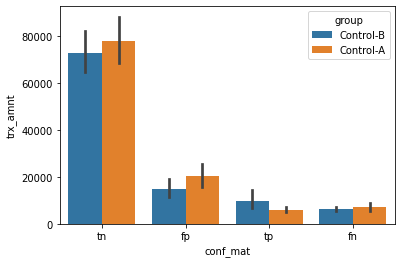

In [45]:
sns.barplot(
    data=dc[msk],
    x='conf_mat',
    y='trx_amnt',
    hue='group',
    estimator=sum
)

In [43]:
get_recall(all_decisions, 'correct')

,group,mean,n,se,var
0,Control-A,0.480221,495,0.053577,1.420893
1,Control-B,0.491617,499,0.051814,1.339640
2,Irrelevant,0.305383,499,0.057377,1.642771
3,LIME,0.384653,499,0.053488,1.427635
4,Random,0.386736,496,0.049038,1.192762
5,TreeInt,0.407702,496,0.061235,1.859892
6,TreeSHAP,0.378531,497,0.057587,1.648177


In [ ]:
all_decisions

#### Recall

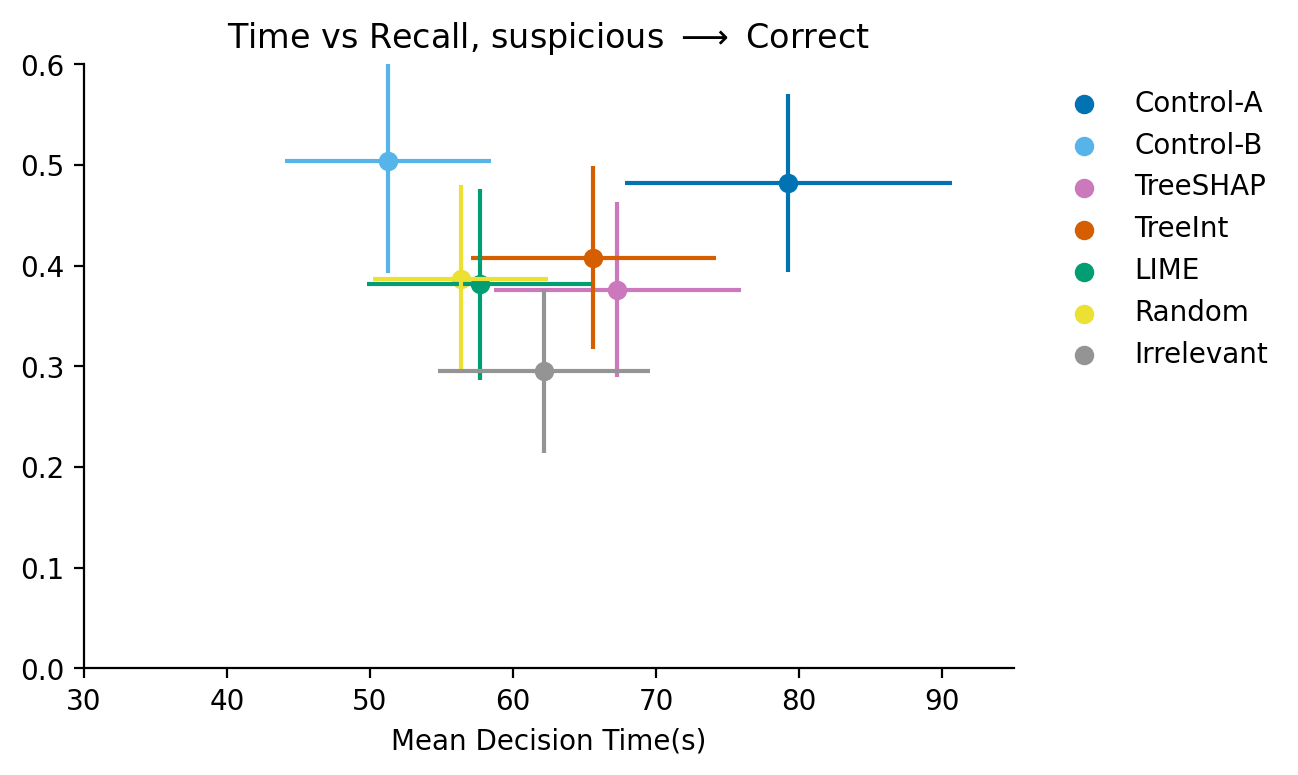

In [20]:
xlim = [30, 95]
ylim = [0, 0.60]

recall = get_recall(all_decisions, 'correct')
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Correct'
                            , xlim=xlim, ylim=ylim)


# recall = get_recall(all_decisions, 'approve')
# dt_df = dt(all_decisions, params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Approve'
#                             , xlim=xlim, ylim=ylim)

# recall = get_recall(all_decisions, 'decline')
# dt_df = dt(all_decisions, params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Decline'
#                             , xlim=xlim, ylim=ylim)

# recall = get_recall(all_decisions[~msk], 'approve')
# dt_df = dt(all_decisions[~msk], params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Ignore'
#                             , xlim=xlim, ylim=ylim)

#### FPR

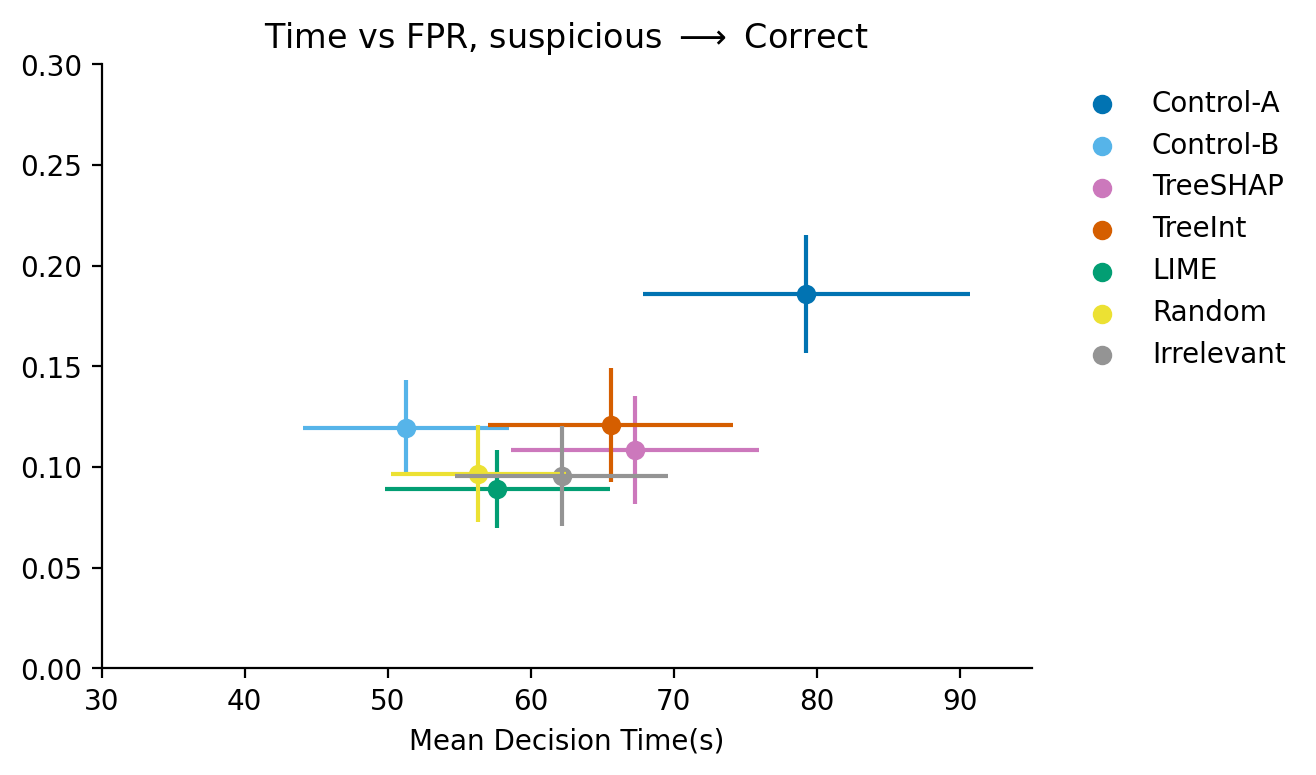

In [21]:
xlim = [30, 95]
ylim = [0, 0.30]


fpr = get_fpr(all_decisions, 'correct')
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Correct'
                            , xlim=xlim, ylim=ylim)


# fpr = get_fpr(all_decisions, 'approve')
# dt_df = dt(all_decisions, params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Approve'
#                             , xlim=xlim, ylim=ylim)

# fpr = get_fpr(all_decisions, 'decline')
# dt_df = dt(all_decisions, params, 'decline', ['group'])
# plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Decline'
#                             , xlim=xlim, ylim=ylim)

# fpr = get_fpr(all_decisions[~msk], 'approve')
# dt_df = dt(all_decisions[~msk], params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Ignore'
#                             , xlim=xlim, ylim=ylim)


### Precision

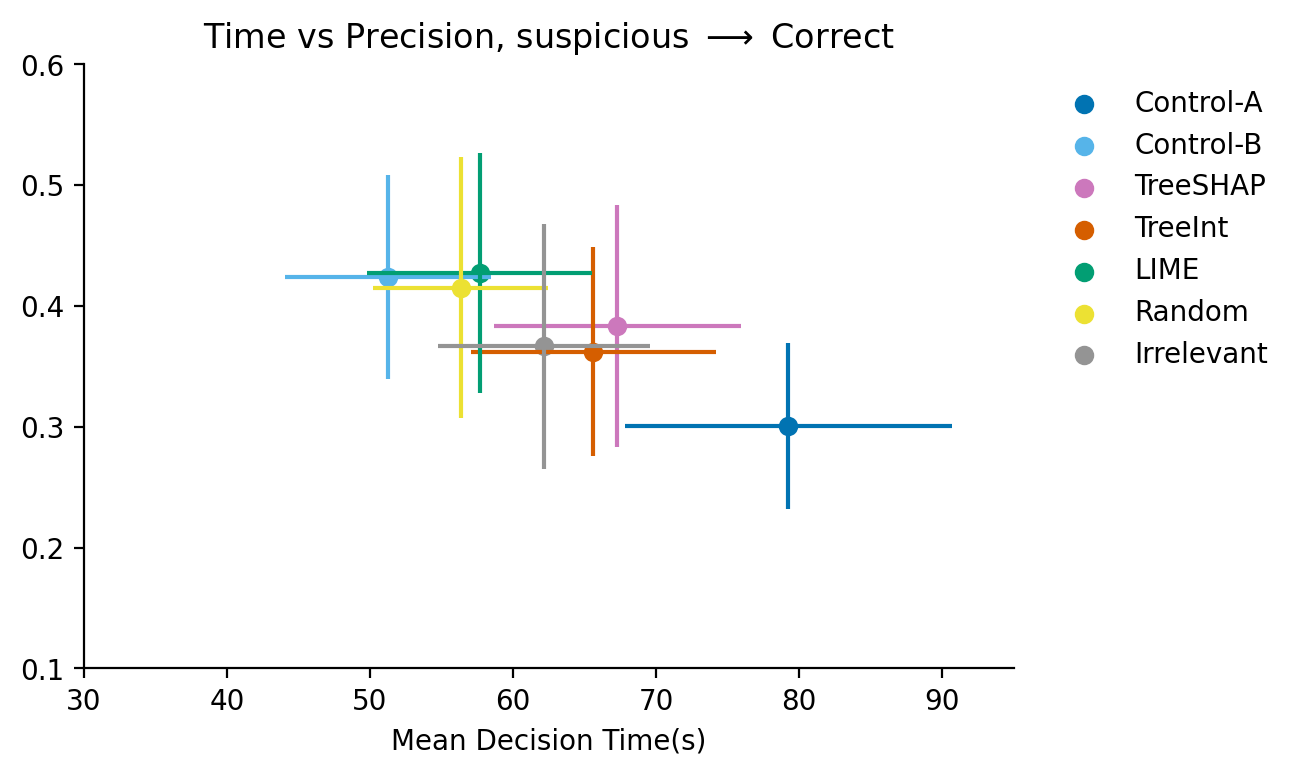

In [22]:
xlim = [30, 95]
ylim = [0.1, 0.60]


precision = get_precision(all_decisions, 'correct')
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Correct'
                            , xlim=xlim, ylim=ylim)


# precision = get_precision(all_decisions, 'approve')
# dt_df = dt(all_decisions, params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Approve'
#                             , xlim=xlim, ylim=ylim)

# precision = get_precision(all_decisions, 'decline')
# dt_df = dt(all_decisions, params, 'decline', ['group'])
# plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Decline'
#                             , xlim=xlim, ylim=ylim)

# precision = get_precision(all_decisions[~msk], 'approve')
# dt_df = dt(all_decisions[~msk], params, 'approve', ['group'])
# plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Ignore'
#                             , xlim=xlim, ylim=ylim)

#### Summary

In [29]:
def get_decision_rates(decisions, agg_levels=['group']):
    
    grpobj = decisions.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
                
        app = df['decision'] == 'approved'
        dec = df['decision'] == 'declined'
        sus = df['decision'] == 'suspicious'
        
        
                
        d['approval_pct'] = len(df[app]) / len(df)
        d['decline_pct'] = len(df[dec]) / len(df)
        d['suspicious_pct'] = len(df[sus]) / len(df)

        
        res.append(d)
        
    return pd.DataFrame(res)

In [34]:
cols = ['group', 'mean']

dt_mean = dt(all_decisions, params, 'correct', ['group'])[cols].rename(columns={'mean': 'time'})

pdr_mean = pdr(all_decisions, params, 'correct', ['group'], n_samples=500, n_iterations=1000)[cols].rename(columns={'mean': 'pdr'})
pdr_mean['pdr'] = pdr_mean['pdr'] * 100

acc = get_accuracy(all_decisions, 'correct',  n_samples=500, n_iterations=1000)[cols].rename(columns={'mean': 'acc'})
acc['acc'] = acc['acc'] * 100

fpr = get_fpr(all_decisions, 'correct',  n_samples=500, n_iterations=1000)[cols].rename(columns={'mean': 'fpr'})
fpr['fpr'] = fpr['fpr'] * 100

recall = get_recall(all_decisions, 'correct',  n_samples=500, n_iterations=1000)[cols].rename(columns={'mean': 'recall'})
recall['recall'] = recall['recall'] * 100

precision = get_precision(all_decisions, 'correct',  n_samples=500, n_iterations=1000)[cols].rename(columns={'mean': 'precision'})
precision['precision'] = precision['precision'] * 100

decision_rates = get_decision_rates(all_decisions, ['group'])
decision_rates[['approval_pct', 'decline_pct', 'suspicious_pct']] = decision_rates[['approval_pct', 'decline_pct', 'suspicious_pct']] * 100

dfs = [pdr_mean, dt_mean, acc, fpr, recall, precision, decision_rates]
summary_table = reduce(lambda  left,right: pd.merge(left,right, on=['group'],how='outer'), dfs)

summary_table = round(summary_table, 2)
summary_table.to_csv('results/summary_suspicious_correct.csv', index=False)

In [119]:
# dt_mean = dt(all_decisions, params, 'approve', ['group'])[cols].rename(columns={'mean': 'mean_time'})
# acc = get_accuracy(all_decisions, 'approve')[cols].rename(columns={'mean': 'acc'})
# fpr = get_fpr(all_decisions, 'approve')[cols].rename(columns={'mean': 'fpr'})
# recall = get_recall(all_decisions, 'approve')[cols].rename(columns={'mean': 'recall'})
# precision = get_precision(all_decisions, 'approve')[cols].rename(columns={'mean': 'precision'})
# decision_rates = get_decision_rates(all_decisions, ['group'])

# dfs = [dt_mean, decision_rates, acc, fpr, recall, precision]
# summary_table = reduce(lambda  left,right: pd.merge(left,right, on=['group'],how='outer'), dfs)

# summary_table = round(summary_table, 3)
# summary_table.to_csv('summary_suspicious_approve.csv', index=False)

In [120]:
# dt_mean = dt(all_decisions, params, 'decline', ['group'])[cols].rename(columns={'mean': 'mean_time'})
# acc = get_accuracy(all_decisions, 'decline')[cols].rename(columns={'mean': 'acc'})
# fpr = get_fpr(all_decisions, 'decline')[cols].rename(columns={'mean': 'fpr'})
# recall = get_recall(all_decisions, 'decline')[cols].rename(columns={'mean': 'recall'})
# precision = get_precision(all_decisions, 'decline')[cols].rename(columns={'mean': 'precision'})
# decision_rates = get_decision_rates(all_decisions, ['group'])

# dfs = [dt_mean, decision_rates, acc, fpr, recall, precision]
# summary_table = reduce(lambda  left,right: pd.merge(left,right, on=['group'],how='outer'), dfs)

# summary_table = round(summary_table, 3)
# summary_table.to_csv('summary_suspicious_decline.csv', index=False)

#### By USer

In [101]:
fpr = get_fpr(all_decisions, 'correct', ['group', 'user_name'])
dt_df = dt(all_decisions, params, 'correct', ['group', 'user_name'])
# plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Correct'
#                             , xlim=xlim, ylim=ylim)

In [100]:
dt_df

,group,mean,n,se,user_name,var
0,Control-A,46.335329,167,9.090137,j,13799.308564
1,Control-A,101.654545,165,12.980330,n,27800.678714
2,Control-A,90.269939,163,13.291146,t,28794.692115
3,Control-B,23.479042,167,3.995866,j,2666.479980
4,Control-B,56.524096,166,3.188363,n,1687.499416
5,Control-B,74.036145,166,11.801312,t,23118.980504
6,Irrelevant,26.133333,165,4.122671,j,2804.408943
7,Irrelevant,107.556886,167,10.683180,n,19059.766323
8,Irrelevant,52.347305,167,5.607454,t,5251.071423
9,LIME,23.728916,166,5.598521,j,5203.010916


#### Considering only J & T

In [12]:
n_msk = all_decisions['user_name'] == 'n'

jt_decisions = all_decisions[~n_msk]

decision_rates_jt = get_decision_rates(jt_decisions, ['group'])

decision_rates_jt

,approval_pct,decline_pct,group,suspicious_pct
0,0.751515,0.193939,Control-A,0.054545
1,0.831832,0.135135,Control-B,0.033033
2,0.876506,0.114458,Irrelevant,0.009036
3,0.855422,0.111446,LIME,0.033133
4,0.888218,0.105740,Random,0.006042
5,0.873112,0.105740,TreeInt,0.021148
6,0.830816,0.123867,TreeSHAP,0.045317


In [13]:
n_decisions = all_decisions[n_msk]

decision_rates_n = get_decision_rates(n_decisions, ['group'])

decision_rates_n

,approval_pct,decline_pct,group,suspicious_pct
0,0.648485,0.284848,Control-A,0.066667
1,0.759036,0.240964,Control-B,0.000000
2,0.820359,0.149701,Irrelevant,0.029940
3,0.844311,0.143713,LIME,0.011976
4,0.787879,0.187879,Random,0.024242
5,0.703030,0.254545,TreeInt,0.042424
6,0.831325,0.162651,TreeSHAP,0.006024


#### Accuracy Metrics Stat tests

In [9]:
dc = all_decisions.copy()    
dc['conf_mat'] = assign_conf_mat_cell(dc, 'correct')
grp_obj = dc.groupby('group')

In [10]:
conf_mat = {
    "accuracy": {
        "pos": ["tp", "tn"],
        "neg": ["fp", "fn"]
    },
     "fpr": {
        "pos": ["fp"],
        "neg": ["tn"]
     },
    "recall": {
        "pos": ["tp"],
        "neg": ["fn"]
    }
}

freq_mat = dict()
for metric in conf_mat.keys():
    d = dict()
    for grp, df in grp_obj:
        positives = np.sum([df[df['conf_mat']==cell].shape[0] for cell in conf_mat[metric]['pos']])
        negatives = np.sum([df[df['conf_mat']==cell].shape[0] for cell in conf_mat[metric]['neg']])
    
        d[grp] = [positives, negatives]
        
    freq_mat[metric] = d

In [11]:
freq_mat

{'accuracy': {'Data': [379, 116],
  'Irrelevant': [405, 94],
  'LIME': [415, 84],
  'ML Model': [410, 89],
  'Random': [410, 86],
  'TreeInt': [401, 95],
  'TreeSHAP': [407, 90]},
 'fpr': {'Data': [79, 344],
  'Irrelevant': [40, 382],
  'LIME': [38, 386],
  'ML Model': [51, 373],
  'Random': [40, 381],
  'TreeInt': [51, 371],
  'TreeSHAP': [45, 379]},
 'recall': {'Data': [35, 37],
  'Irrelevant': [23, 54],
  'LIME': [29, 46],
  'ML Model': [37, 38],
  'Random': [29, 46],
  'TreeInt': [30, 44],
  'TreeSHAP': [28, 45]}}

In [12]:
comparisons = [
    ('Data', 'ML Model'),
    ('ML Model', 'LIME'),
    ('ML Model', 'TreeInt'),
    ('ML Model', 'TreeSHAP'),
    ('ML Model', 'Random'),
    ('ML Model', 'Irrelevant'),
    ('Random', 'TreeInt'),
    ('Random', 'TreeSHAP'),
    ('Random', 'LIME'),
    ('Irrelevant', 'TreeInt'),
    ('Irrelevant', 'TreeSHAP'),
    ('Irrelevant', 'LIME'),
    ('Irrelevant', 'Random'),
    ('LIME', 'TreeSHAP'),
    ('LIME', 'TreeInt'),
    ('TreeSHAP', 'TreeInt')
]

In [15]:
p_val_dfs = dict()

for metric in conf_mat.keys():
    contingency = freq_mat[metric]
    res = list()
    for comp in comparisons:
        contingency_table = [contingency[comp[0]], contingency[comp[1]]]
        
        stat, p_val = chi_square_test(np.array(contingency_table))
        d = dict()
        d['comparison'] = comp
        d['p-val'] = p_val
        
        res.append(d)
    
    p_val_dfs[metric] = pd.DataFrame(res)

In [17]:
df = p_val_dfs['accuracy']
msk = df['p-val'] < 0.1
df[msk]

,comparison,p-val
0,"(Data, ML Model)",0.029161


In [18]:
df = p_val_dfs['fpr']
msk = df['p-val'] < 0.1
df[msk]

,comparison,p-val
0,"(Data, ML Model)",0.00728


In [21]:
df = p_val_dfs['recall']
msk = df['p-val'] < 0.1
df[msk]

,comparison,p-val
5,"(ML Model, Irrelevant)",0.014113
